In [1]:
%config Completer.use_jedi = False

In [2]:
import sys
from model import atp_graph, atp_pipeline, model_init
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
import os
plt.style.use('ggplot')
import pandas as pd
%matplotlib inline
from data_wrangler import batcher
import warnings
warnings.filterwarnings("ignore")

In [3]:
gcm_nigeria = pd.read_csv("/Users/omernivron/Downloads/hw2/ipsl.csv").iloc[:, 3:]
era_nigeria = pd.read_csv("/Users/omernivron/Downloads/hw2/era.csv").iloc[:, 4:]

In [4]:
era_nigeria = era_nigeria[(era_nigeria.year >= 1948) & (era_nigeria.year < 2015)]
gcm_nigeria = gcm_nigeria[(gcm_nigeria.year >= 1948) & (gcm_nigeria.year < 2015) & (gcm_nigeria.axis_nbounds == 0)]

In [5]:
df = gcm_nigeria.groupby(['lat', 'lon']).mean().reset_index()
df['loc_key'] = np.arange(df.shape[0])
df = df[['lat', 'lon', 'loc_key']]
gcm_nigeria = pd.merge(gcm_nigeria, df, how='left', on=['lat', 'lon'])

In [6]:
df_e = era_nigeria.groupby(['lat', 'lon']).mean().reset_index()
df_e['loc_key'] = np.arange(df_e.shape[0])
df_e = df_e[['lat', 'lon', 'loc_key']]
era_nigeria = pd.merge(era_nigeria, df_e, how='left', on=['lat', 'lon'])

In [7]:
era_nigeria['t'] = era_nigeria['year'] + ((era_nigeria['month'] - 1)/ 12) + ((era_nigeria['day'] - 1)/ (12 *31))
gcm_nigeria['t'] = gcm_nigeria['year'] + ((gcm_nigeria['month'] - 1)/ 12)+ ((gcm_nigeria['day'] - 1)/ (12 *31))

In [8]:
era_mon_nigeria = era_nigeria.groupby(['grid_val','loc_key','t']).mean().reset_index()
gcm_mon_nigeria = gcm_nigeria.groupby(['grid_val','loc_key', 't']).mean().reset_index()

In [11]:
era_mon_nigeria['tmax'] = era_mon_nigeria['tmax'] - 273.15 
gcm_mon_nigeria['tasmax'] = gcm_mon_nigeria['tasmax'] - 273.15 

In [12]:
μ_era_past = era_mon_nigeria[(era_mon_nigeria.t > 1948) & (era_mon_nigeria.t  < 1989)].groupby(['grid_val', 'loc_key']).mean()['tmax'].reset_index()
μ_gcm_past = gcm_mon_nigeria[(gcm_mon_nigeria.t > 1948) & (gcm_mon_nigeria.t  < 1989)].groupby(['grid_val', 'loc_key']).mean()['tasmax'].reset_index()

σ_era_past = era_mon_nigeria[(era_mon_nigeria.t > 1948) & (era_mon_nigeria.t  < 1989)].groupby(['grid_val', 'loc_key']).std()['tmax'].reset_index()
σ_gcm_past = gcm_mon_nigeria[(gcm_mon_nigeria.t > 1948) & (gcm_mon_nigeria.t  < 1989)].groupby(['grid_val', 'loc_key']).std()['tasmax'].reset_index()

In [13]:
era_mon_nigeria = pd.merge(era_mon_nigeria, μ_era_past, on=['grid_val', 'loc_key'], how='left', suffixes=('', '_mu'))
era_mon_nigeria = pd.merge(era_mon_nigeria, σ_era_past, on=['grid_val', 'loc_key'], how='left', suffixes=('', '_sigma'))


In [14]:
gcm_mon_nigeria = pd.merge(gcm_mon_nigeria, μ_gcm_past, on=['grid_val', 'loc_key'], how='left', suffixes=('', '_mu'))
gcm_mon_nigeria = pd.merge(gcm_mon_nigeria, σ_gcm_past, on=['grid_val', 'loc_key'], how='left', suffixes=('', '_sigma'))

In [15]:
era_mon_nigeria = era_mon_nigeria[era_mon_nigeria.grid_val!=25]
era_mon_nigeria = era_mon_nigeria[era_mon_nigeria.grid_val!=8]
gcm_mon_nigeria = gcm_mon_nigeria[gcm_mon_nigeria.grid_val!=25]

In [16]:
era_mon_nigeria['era_adj_tmax'] = (era_mon_nigeria.tmax - era_mon_nigeria.tmax_mu) / era_mon_nigeria.tmax_sigma 
gcm_mon_nigeria['gcm_adj_tasmax'] = (gcm_mon_nigeria.tasmax - gcm_mon_nigeria.tasmax_mu) / gcm_mon_nigeria.tasmax_sigma

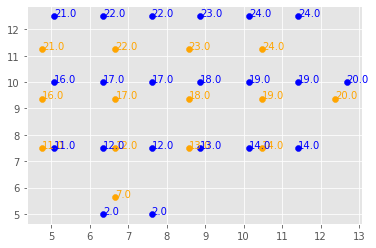

In [17]:

a = era_mon_nigeria.groupby(['lat', 'lon']).mean().reset_index()
b = gcm_mon_nigeria.groupby(['lat', 'lon']).mean().reset_index()
plt.scatter(a['lat'], a['lon'], c='orange')
plt.scatter(b['lat'], b['lon'], c='b') 
for i in range(a.shape[0]):
    plt.text(a['lat'][i], a['lon'][i], str(a['grid_val'][i]), c='orange')
for i in range(b.shape[0]):
    plt.text(b['lat'][i], b['lon'][i], str(b['grid_val'][i]), c='b')

In [18]:
# prepare data for batcher_bc
array = pd.merge(era_mon_nigeria, gcm_mon_nigeria, on=['grid_val', 't'], how='inner', suffixes=('', '_gcm'))
### check if merge is correct
# array.loc[array.grid_val==r_grid_val, ['loc_key', 'loc_key_gcm', 't', 'adj_tmax', 'adj_tasmax']]
####

In [19]:
m = model_init.model_init('leak', 2, 'forecasting/bc/', multiply = 2, bc=True, subsample = False)
ckpt, manager = m.load_model()

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-06-01 13:22:44.189340: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-01 13:22:44.189523: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [18]:
r_grid_val = np.random.choice(np.unique(array.grid_val), 1)[0]
r_loc_key = np.random.choice(np.unique(array.loc[array.grid_val==r_grid_val, ['loc_key_gcm']]), 1)[0]
arr_temp = array.loc[(array.t < 1989) & (array.grid_val==r_grid_val) & (array.loc_key_gcm == r_loc_key), ['t', 'gcm_adj_tasmax', 'era_adj_tmax']].reset_index(drop=True)
x, y = batcher.batcher_bc(np.array(arr_temp.reset_index(drop=True)), 180, batch_size=32)

In [19]:
## x dim batch_size, seq_len, alpha
## y dim batch_size, seq_len
n_C = [180, 90]
n_T = [0, 90]
n_C_s = [0, 0]
n_T_s = [0, 0]
mu , sig, y1 = m.model([x, y[:, :, np.newaxis], n_C, n_T, True, n_C_s, n_T_s])

subsample: False
multiply: 2
bc: True
x shape: (32, 360, 1)
y shape: (32, 360, 1)
x.shape (32, 360, 1)


InvalidArgumentError: Exception encountered when calling layer "atp_pipeline" (type atp_pipeline).

index innermost dimension length must be <= params rank; saw:  [Op:GatherNd]

Call arguments received:
  • inputs=['tf.Tensor(shape=(32, 360, 1), dtype=float32)', 'tf.Tensor(shape=(32, 360, 1), dtype=float32)', ['tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)'], ['tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)'], 'tf.Tensor(shape=(), dtype=bool)', ['tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)'], ['tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)']]

In [20]:
tr_step = atp_graph.build_graph()

In [21]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)

In [22]:
import IPython
from model import losses

In [23]:
n_C = np.array([180, 90])
n_T = np.array([0, 45])
n_C_s = np.array([0, 0])
n_T_s = np.array([0, 0])
n_T_tot = 45
n_C_tot = 270

In [22]:
mini = 1000
EPOCHS = 100
num_batches = int(array.shape[0] / 32)
for epoch in range(EPOCHS):
    start = time.time()
    for batch_n in range(num_batches):
        r_grid_val = np.random.choice(np.unique(array.grid_val), 1)[0]
        r_loc_key = np.random.choice(np.unique(array.loc[array.grid_val==r_grid_val, ['loc_key_gcm']]), 1)[0]
        arr_temp = array.loc[(array.t < 1989) & (array.grid_val==r_grid_val) & (array.loc_key_gcm == r_loc_key), ['t', 'gcm_adj_tasmax', 'era_adj_tmax']].reset_index(drop=True)
        x, y = batcher.batcher_bc(np.array(arr_temp.reset_index(drop=True)), 180, batch_size=32)
        μ, log_sig, likpp, mse =  tr_step(m.model, optimizer, x, y[:, :, np.newaxis], n_C, n_T, training = True, n_C_s = n_C_s, n_T_s = n_T_s, n_T_tot = n_T_tot, n_C_tot = n_C_tot)
        if ((batch_n % 100 == 0)):
            r_grid_val = np.random.choice(np.unique(array.grid_val), 1)[0]
            r_loc_key = np.random.choice(np.unique(array.loc[array.grid_val==r_grid_val, ['loc_key_gcm']]), 1)[0]
            arr_temp = array.loc[(array.t >= 1989) & (array.grid_val==r_grid_val) & (array.loc_key_gcm == r_loc_key), ['t', 'gcm_adj_tasmax', 'era_adj_tmax']].reset_index(drop=True)
            x, y = batcher.batcher_bc(np.array(arr_temp.reset_index(drop=True)), 180, batch_size=32)
            μ , log_sig, y1 = m.model([x, y[:, :, np.newaxis], n_C, n_T, False, n_C_s, n_T_s, n_C_tot, n_T_tot])
            _, _, _, likpp, mse = losses.nll(y1, μ, log_sig)
            if likpp < mini:
                mini = likpp
                IPython.display.clear_output(wait=True)
                print("epoch {} batch {} test lik pp: {}".format(epoch, batch_n, likpp)) 
                plt.plot(y1[0, :], label='gt')
                plt.plot(μ[0, :], label='pred')
                plt.legend()
                plt.show()
                ckpt.step.assign_add(1)
                manager.save()

subsample: False
multiply: 2
bc: True
x shape: (32, 360, 1)
y shape: (32, 360, 1)
x.shape (32, 360, 1)
x_temp.shape Tensor("atp_pipeline/Shape:0", shape=(3,), dtype=int32)
1d
#######
Tensor("atp_pipeline/de/cond/ones:0", shape=(None, None), dtype=float32)
Tensor("atp_pipeline/de/cond/ones_1:0", shape=(None, None), dtype=bool)
#######
x.shape (32, 360, 1)
x_temp.shape Tensor("atp_pipeline/Shape_1:0", shape=(3,), dtype=int32)
1d
#######
Tensor("atp_pipeline/de/cond_1/ones:0", shape=(None, None), dtype=float32)
Tensor("atp_pipeline/de/cond_1/ones_1:0", shape=(None, None), dtype=bool)
#######
here
FEATURE WRAPPER
x_emb:  (32, None, 34)
y:  (32, None, 1)
y_diff:  (32, None, 1)
x_diff:  (32, None, 1)
d:  (32, None, 2)
x_n:  (32, None, 1)
y_n:  (32, None, 1)
n_C:  Tensor("atp_pipeline/Const_2:0", shape=(), dtype=int32)
n_T:  Tensor("atp_pipeline/Const_3:0", shape=(), dtype=int32)
END FEATURE WRAPPER
x_prime:  (32, None, 36)
n_C pre-mask: 270
n_T pre-mask: 45
n_C:  270
n_T:  45
diagonal_mask: 

2023-06-01 12:45:25.561667: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-01 12:45:25.563355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


subsample: False
multiply: 2
bc: True
x shape: (32, 360, 1)
y shape: (32, 360, 1)
x.shape (32, 360, 1)
x_temp.shape tf.Tensor([ 32 180   1], shape=(3,), dtype=int32)
1d
x.shape (32, 360, 1)
x_temp.shape tf.Tensor([ 32 135   1], shape=(3,), dtype=int32)
1d
#######
tf.Tensor(
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]], shape=(45, 135), dtype=float32)
tf.Tensor(
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]], shape=(45, 135), dtype=bool)
#######
here
FEATURE WRAPPER
x_emb:  (32, 315, 34)
y:  (32, 315, 1)
y_diff:  (32, 315, 1)
x_diff:  (32, 315, 1)
d:  (32, 315, 2)
x_n:  (32, 315, 1)
y_n:  (32, 315, 1)
n_C:  tf.Tensor(270, shape=(), dtype=int32)
n_T:  tf.Tensor(45, 

ValueError: too many values to unpack (expected 4)

In [25]:
print(tf.__version__)

2.8.0


In [25]:
x = np.random.normal(0, 1, (2, 10))

In [31]:
x.shape

(2, 10)

In [26]:
ts_start = 4
ts_end = 8

In [34]:
tf.reshape(tf.range(ts_start, ts_end), (1, -1))

<tf.Tensor: shape=(1, 4), dtype=int32, numpy=array([[4, 5, 6, 7]], dtype=int32)>

In [42]:
x.shape

(2, 10)

In [40]:
p

<tf.Tensor: shape=(2, 4), dtype=int32, numpy=
array([[4, 5, 6, 7],
       [4, 5, 6, 7]], dtype=int32)>

In [46]:
p = tf.repeat(tf.reshape(tf.range(ts_start, ts_end), (1, -1)), 1, axis=0)
x_temp = tf.gather(x, indices = p, axis=1)


In [47]:
x_temp

<tf.Tensor: shape=(2, 1, 4), dtype=float64, numpy=
array([[[ 0.06327025, -1.51325949, -0.44097281, -0.14728801]],

       [[ 0.89138603, -0.44479277,  0.47417843, -0.53936076]]])>

In [48]:
x

array([[-0.2280183 , -0.04767794,  1.84492864, -0.52492692,  0.06327025,
        -1.51325949, -0.44097281, -0.14728801,  1.00956708, -0.48982951],
       [ 1.66513019, -0.23367672,  0.3690821 , -0.48533278,  0.89138603,
        -0.44479277,  0.47417843, -0.53936076, -1.10765534, -1.62125557]])

In [24]:
tf.range(ts_start, ts_end, dtype=tf.int32)

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([4, 5, 6, 7], dtype=int32)>

In [ ]:
x_temp = tf.slice(x, ts_start, ts_end - ts_start, name=None)


In [ ]:
# TO DO:
# We want to have n_C and n_T with different sizes per time series